In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load the dataset from the correct file path

In [ ]:
file_path = "../data/iyp-validation-dataset.xlsx"
df = pd.read_excel(file_path)

### Extract relevant columns

In [3]:
metric_columns = ['BLEU Score', 'ROUGE-1 F1 Score', 'ROUGE-L F1 Score', 'G-Eval Score', 'BERTScore', 'BERTScore Normalized']
metric_columns_no_norm = ['BLEU Score', 'ROUGE-1 F1 Score', 'ROUGE-L F1 Score', 'G-Eval Score', 'BERTScore']
metric_columns.sort()

difficulty_column = 'Difficulty'
metrics_df = df[metric_columns + [difficulty_column]].dropna()
metrics_df = metrics_df.reindex(sorted(metrics_df.columns), axis=1)

metrics_df[metric_columns].head()

,BERTScore,BERTScore Normalized,BLEU Score,G-Eval Score,ROUGE-1 F1 Score,ROUGE-L F1 Score
0,0.804541,0.241122,3.351073e-232,0.100000,0.156863,0.117647
1,0.958499,0.838869,4.721738e-01,0.400204,0.813559,0.779661
2,0.943810,0.781838,7.140574e-01,0.200000,0.875000,0.833333
3,0.936230,0.752408,8.633400e-01,0.300000,0.818182,0.818182
4,0.881960,0.541704,2.656356e-01,0.300000,0.488372,0.441860


### Set up the plotting style

In [ ]:
sns.set_style("whitegrid")
custom_palette = ["#093F6B", "#2782BF", "#1F8671", "#35A17A", "#FFC000", "#C70039"]
difficulty_palette = ["#1F8671", "#4DCFA6", "#FFC000", "#093F6B", "#2782BF", "#C70039", "#FF5733"]
# Define consistent bin edges
bin_edges = np.histogram_bin_edges(metrics_df[metric_columns].values.flatten(), bins=15)

***
## Evaluation section

### BLEU Analysis

To evaluate the RAG model on the custom IYP dataset, BLEU scores measure lexical similarity between generated responses and ground truth answers. Scores range from 0 (no overlap) to 1 (exact match). The distribution is relatively flat, with a noticeable spike at 0.0, indicating many responses are entirely incorrect or unrelated.

High BLEU scores do not always reflect factual accuracy. For example, a response stating the number of Autonomous Systems in the US is “0” scores 0.95 due to structural similarity, despite being factually wrong. Conversely, some accurate and detailed responses receive low scores simply because they use different wording.

Overall, BLEU captures surface-level similarity but fails to assess semantic correctness, numerical accuracy, or valid rephrasings, making it a poor fit for evaluating fact-sensitive, graph-based QA.

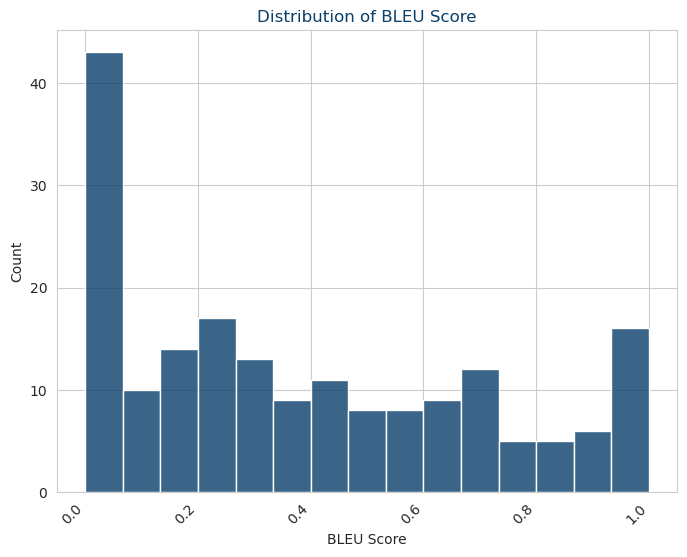

In [6]:
metric = 'BLEU Score'

plt.figure(figsize=(8, 6))
sns.histplot(metrics_df[metric], kde=False, bins=bin_edges, color=custom_palette[0], alpha=0.8)
plt.title(f'Distribution of {metric}', color="#093F6B")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.show()

### ROUGE Analysis

Alongside BLEU, ROUGE is used to evaluate the RAG model’s lexical similarity on the IYP dataset. Both ROUGE-1 and ROUGE-L scores are initially computed and found to be highly correlated. Due to this alignment, the analysis focuses on ROUGE-L, which measures the longest common subsequence and better captures structural similarity and rephrasings.

Unlike BLEU, which shows a flat score distribution, ROUGE-L scores tend to cluster toward higher values. This indicates that the model often preserves key sequences from the reference, even when the wording changes. ROUGE-L is more recall-oriented and tolerant of phrasing variation, making it more suitable for fact-sensitive outputs.

However, like BLEU, ROUGE-L also fails to capture factual accuracy. A response claiming there are “0” Autonomous Systems in the US receives a high score (0.96) despite being factually incorrect, simply due to structural overlap. On the other hand, a response that correctly identifies “Japan” and “United States of America” with their IP prefixes scores just 0.36, since its richer phrasing diverges from the reference.

Overall, ROUGE-L offers better handling of paraphrased and enriched content than BLEU but still struggles to reflect semantic correctness. It is chosen as the preferred metric in this evaluation for its more informative distribution and sensitivity to structure.

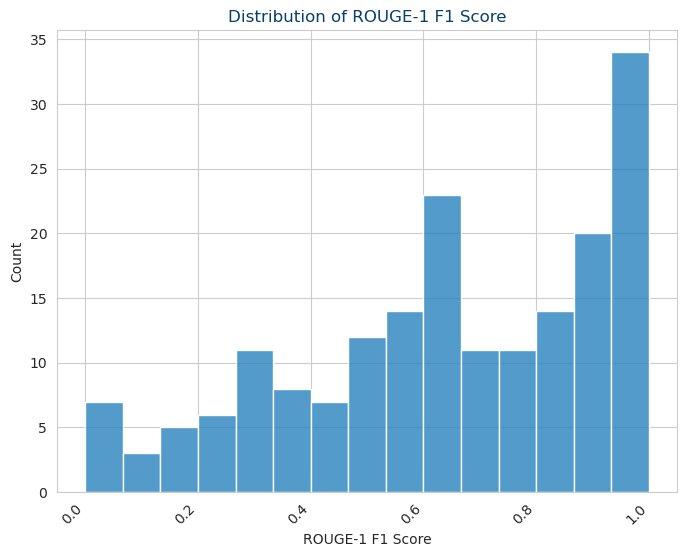

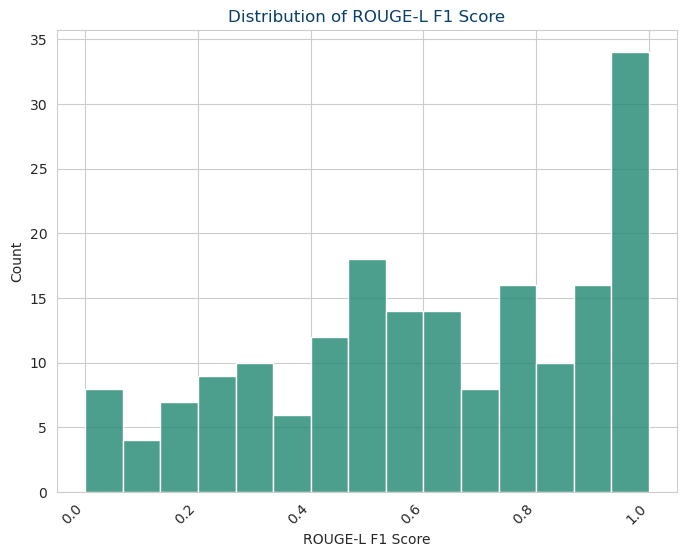

In [7]:
metrics = ['ROUGE-1 F1 Score', 'ROUGE-L F1 Score']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 6))
    sns.histplot(metrics_df[metric], kde=False, bins=bin_edges, color=custom_palette[i % 2 + 1], alpha=0.8)
    plt.title(f'Distribution of {metric}', color="#093F6B")
    plt.xticks(rotation=45, ha='right')  # Rotate x labels
    plt.show()

#### Scatter plot between ROUGE-1 and ROUGE-L

The scatter plot comparing ROUGE-1 and ROUGE-L scores shows a strong positive correlation, especially at higher score ranges. This indicates that when the model produces outputs with high unigram overlap (ROUGE-1), it also tends to preserve longer sequences from the reference answers (ROUGE-L). The close alignment between the two metrics suggests that both capture similar patterns of lexical similarity, but ROUGE-L offers additional insight by accounting for structural continuity. This redundancy justifies focusing the analysis on ROUGE-L, which better reflects the model’s ability to maintain the overall sequence and structure of the reference text.

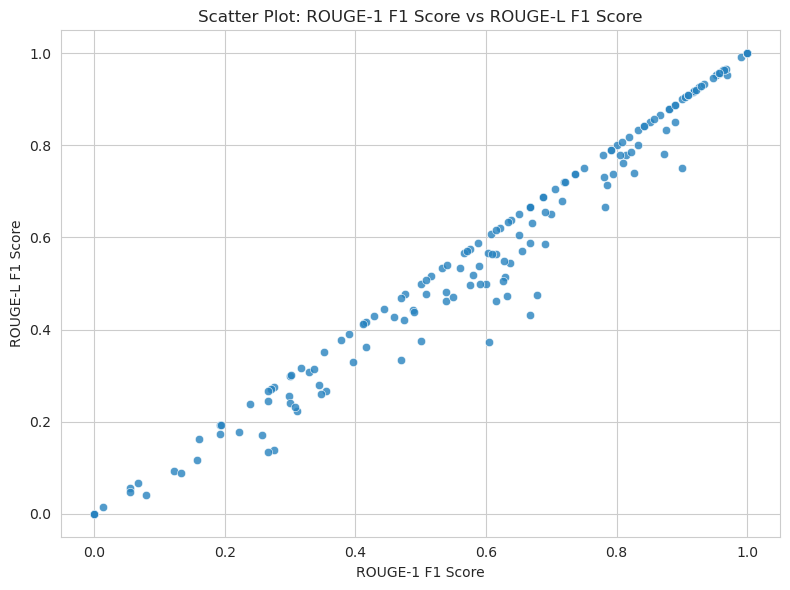

In [8]:
x = "ROUGE-1 F1 Score"
y = "ROUGE-L F1 Score"

plt.figure(figsize=(8, 6))
sns.scatterplot(data=metrics_df , x=x, y=y, color=custom_palette[1], alpha=0.8)
plt.title("Scatter Plot: " + x + " vs " + y)
plt.xlabel(x)
plt.ylabel(y)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Scatter plot between ROUGE-L and BLEU

The scatter plot comparing ROUGE-L and BLEU scores reveals a moderate positive correlation at higher values, where both metrics tend to agree when the generated responses closely match the reference text. However, this correlation weakens at lower scores, highlighting differences in how the two metrics interpret similarity. BLEU, with its emphasis on exact n-gram matches and token order, often assigns low scores to valid rephrasings or enriched answers. In contrast, ROUGE-L, which focuses on recall and sequence overlap, is more forgiving of structural variation. This divergence underscores the limitations of relying solely on lexical metrics and suggests that ROUGE-L provides a slightly more flexible and informative measure for evaluating generated responses in this task.

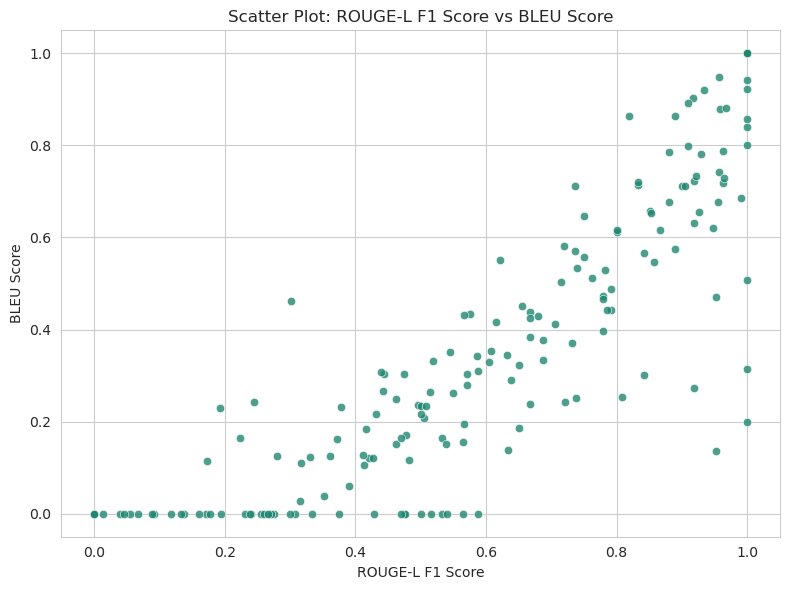

In [9]:
x = "ROUGE-L F1 Score"
y = "BLEU Score"

plt.figure(figsize=(8, 6))
sns.scatterplot(data=metrics_df , x=x, y=y, color=custom_palette[2], alpha=0.8)
plt.title("Scatter Plot: " + x + " vs " + y)
plt.xlabel(x)
plt.ylabel(y)
plt.grid(True)
plt.tight_layout()
plt.show()

### BERTScore Analysis

To complement BLEU and ROUGE, BERTScore is used to assess semantic similarity between the RAG model’s outputs and reference answers on the IYP dataset. Unlike lexical metrics, BERTScore compares contextual embeddings from a pretrained BERT model, offering a meaning-based evaluation rather than exact word overlap.

BERTScore values are generally high, with most responses scoring above 0.74. This is partly due to the uniform and domain-specific nature of the IYP dataset, which causes even unrelated outputs to appear semantically similar in embedding space. As a result, BERTScore struggles to distinguish between low- and high-quality responses in this context.

To improve interpretability, the scores are normalized to a [0,1] range. This normalization maintains the upward trend while revealing more granular differences in output quality. When compared with ROUGE-L, BERTScore shows a strong linear correlation, suggesting both metrics generally rank outputs similarly.

However, BERTScore still fails to penalize factual errors. In a case where the model incorrectly states that the number of ASes in the US is “0,” BERTScore gives a high value of 0.98 (normalized: 0.94), similar to ROUGE and BLEU. It also undervalues accurate, enriched responses with different phrasing—assigning a moderate score of 0.88 (normalized: 0.52) to a semantically correct but elaborated answer.

Due to these limitations, ROUGE-L is preferred over BERTScore. While BERTScore adds value by capturing semantic similarity, its inflated scores, sensitivity to domain mismatch, and limited score variance reduce its effectiveness for evaluating the RAG model on IYP data.

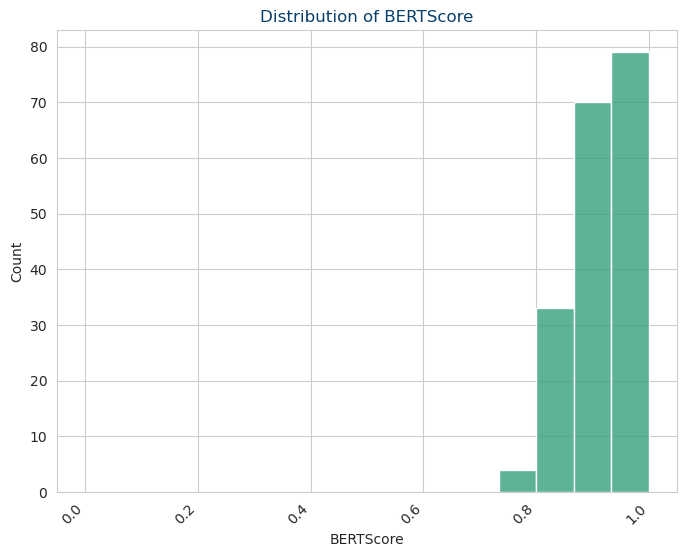

In [10]:
metric = 'BERTScore'

plt.figure(figsize=(8, 6))
sns.histplot(metrics_df[metric], kde=False, bins=bin_edges, color=custom_palette[3], alpha=0.8)
plt.title(f'Distribution of {metric}', color="#093F6B")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.show()

#### Scatter plot between ROUGE-L and BERTScore

The scatter plot comparing ROUGE-L and BERTScore reveals a strong linear correlation, indicating that both metrics tend to rank the RAG model’s outputs similarly in terms of similarity to the reference answers. High ROUGE-L scores generally align with high BERTScore values, especially for responses that closely follow the reference structure and content. However, this correlation is influenced by the domain-specific nature of the IYP dataset, which inflates semantic similarity across outputs in BERTScore due to uniform terminology and structure. While the alignment between the two metrics supports their combined use for evaluating output fidelity, the plot also highlights BERTScore’s compressed value range and reduced sensitivity to factual errors, reinforcing the decision to rely more heavily on ROUGE-L for analysis.

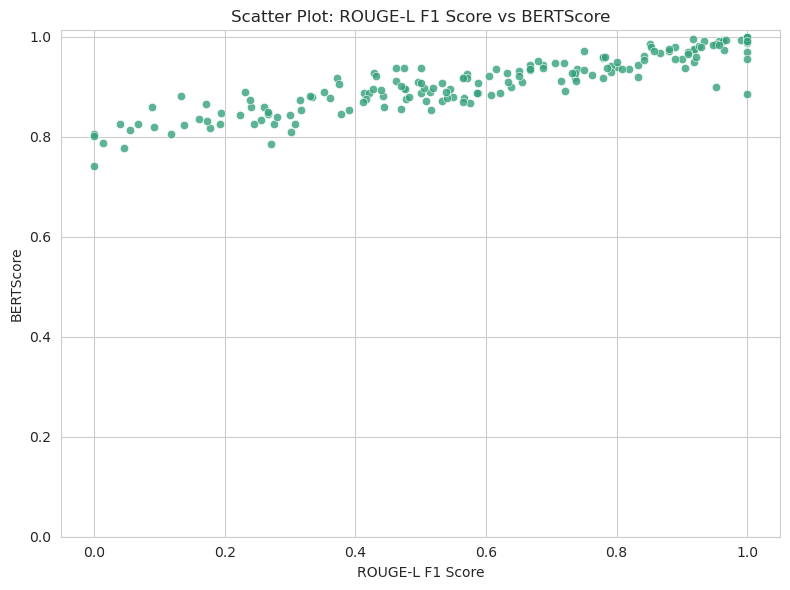

In [11]:
x = "ROUGE-L F1 Score"
y = "BERTScore"

plt.figure(figsize=(8, 6))
sns.scatterplot(data=metrics_df , x=x, y=y, color=custom_palette[3], alpha=0.8)
plt.title("Scatter Plot: " + x + " vs " + y)
plt.xlabel(x)
plt.ylabel(y)
plt.ylim(0, )
plt.grid(True)
plt.tight_layout()
plt.show()

#### Histogram of Normalized BERTScore

BERTScore values are normalized to a [0,1] range to address their compressed distribution and improve interpretability. In the raw scores, even low-quality or factually incorrect responses tend to receive high values due to the domain-specific consistency of the IYP dataset, which leads to high embedding similarity across examples. Normalization helps reveal a clearer gradient of response quality by spreading out the scores and reducing the ceiling effect caused by BERT’s pretrained embedding space. This transformation makes it easier to compare responses and better highlights meaningful differences in semantic alignment that are otherwise obscured in the raw BERTScore values.

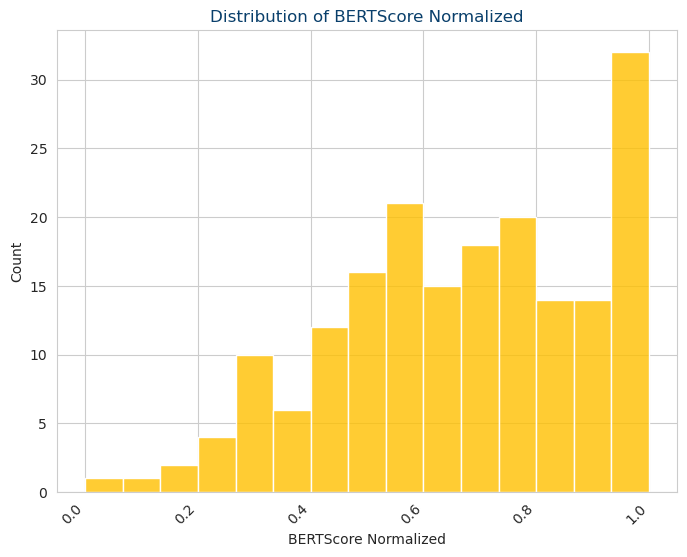

In [12]:
metric = 'BERTScore Normalized'

plt.figure(figsize=(8, 6))
sns.histplot(metrics_df[metric], kde=False, bins=bin_edges, color=custom_palette[4], alpha=0.8)
plt.title(f'Distribution of {metric}', color="#093F6B")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.show()

#### Scatter plot between ROUGE-L and Normalized BERTScore

The scatter plot comparing ROUGE-L and normalized BERTScore shows a clear linear relationship, indicating consistent agreement between the two metrics in ranking the quality of generated responses. Normalizing BERTScore enhances its comparability by reducing compression in the upper range, allowing finer distinctions between outputs. While both metrics tend to score structurally and semantically similar responses highly, the plot reveals that normalized BERTScore offers slightly more differentiation across mid-range outputs. This supports its usefulness as a complementary metric, though ROUGE-L remains more interpretable and less affected by domain-specific embedding bias, making it the more reliable choice for primary evaluation.

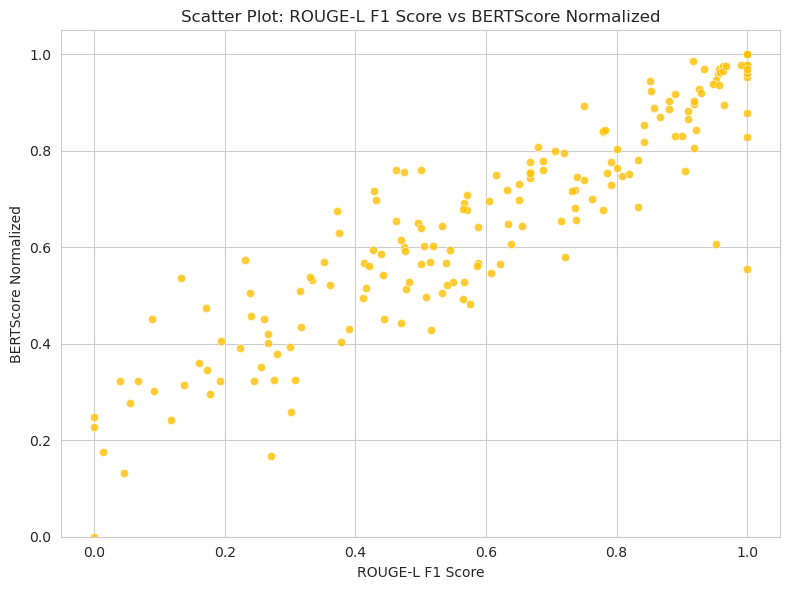

In [13]:
x = "ROUGE-L F1 Score"
y = "BERTScore Normalized"

plt.figure(figsize=(8, 6))
sns.scatterplot(data=metrics_df , x=x, y=y, color=custom_palette[4], alpha=0.8)
plt.title("Scatter Plot: " + x + " vs " + y)
plt.xlabel(x)
plt.ylabel(y)
plt.ylim(0, )
plt.grid(True)
plt.tight_layout()
plt.show()

### G-Eval Analysis

To address the limitations of BLEU, ROUGE, and BERTScore in evaluating semantic and factual accuracy, G-Eval is introduced as a complementary metric. It uses a large language model to score generated responses based on correctness, completeness, and coherence, producing a value between 0 and 1 with a textual justification. Unlike traditional metrics that rely on lexical or embedding similarity, G-Eval assesses the actual content of the response, making it more sensitive to factual correctness and interpretive meaning.

The distribution of G-Eval scores shows a distinct bimodal pattern, with most responses clearly rated as either high or low quality. This reflects the effectiveness of the evaluation prompts, which encourage confident, decisive assessments. Compared to ROUGE-L, the G-Eval scatter plot shows no correlation, highlighting its independence from surface-level similarity. For example, a factually incorrect output stating the number of ASes in the U.S. is “0” receives inflated scores from BLEU (0.95), ROUGE-L (0.96), and BERTScore (0.98, normalized: 0.94), while G-Eval assigns it a much lower and more appropriate score of 0.1. Conversely, a semantically correct but rephrased and enriched response is scored low by BLEU (0.12), ROUGE-L (0.36), and BERTScore (0.88, normalized: 0.52), but G-Eval correctly rewards it with a score of 0.8.

G-Eval avoids overvaluing lexical overlap and better captures semantic correctness, even when outputs deviate from the reference in structure or detail. Its explanatory feedback also aids in identifying failure cases and guiding model improvement. Given these advantages, G-Eval is selected as the preferred metric for evaluating the RAG model’s performance on the IYP dataset.

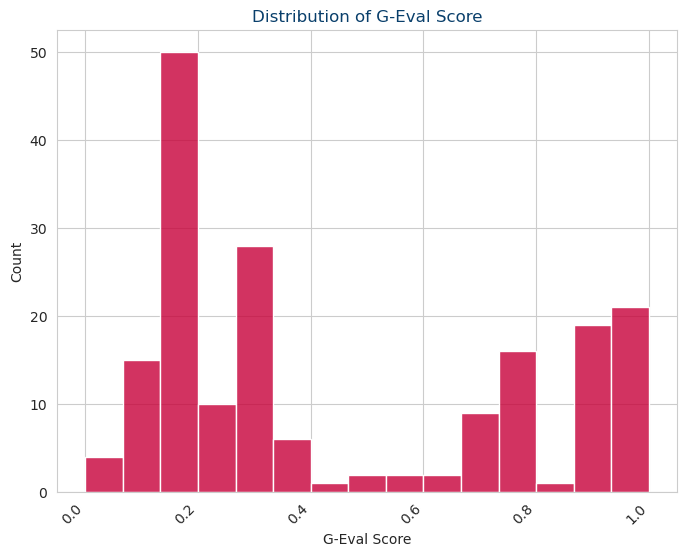

In [14]:
metric = 'G-Eval Score'

plt.figure(figsize=(8, 6))
sns.histplot(metrics_df[metric], kde=False, bins=bin_edges, color=custom_palette[5], alpha=0.8)
plt.title(f'Distribution of {metric}', color="#093F6B")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.show()

#### Scatter plot between G-Eval and ROUGE-L

The scatter plot comparing G-Eval and ROUGE-L scores reveals no meaningful correlation between the two metrics, emphasizing their fundamentally different evaluation strategies. While ROUGE-L focuses on lexical and structural overlap, G-Eval assesses semantic correctness and factual accuracy based on LLM judgment. This lack of alignment is especially visible in cases where ROUGE-L assigns high scores to factually incorrect outputs due to surface similarity, while G-Eval penalizes them appropriately. The plot highlights G-Eval’s ability to distinguish between outputs that merely resemble the reference text and those that are genuinely accurate and coherent, making it a more reliable indicator of response quality in fact-sensitive tasks.

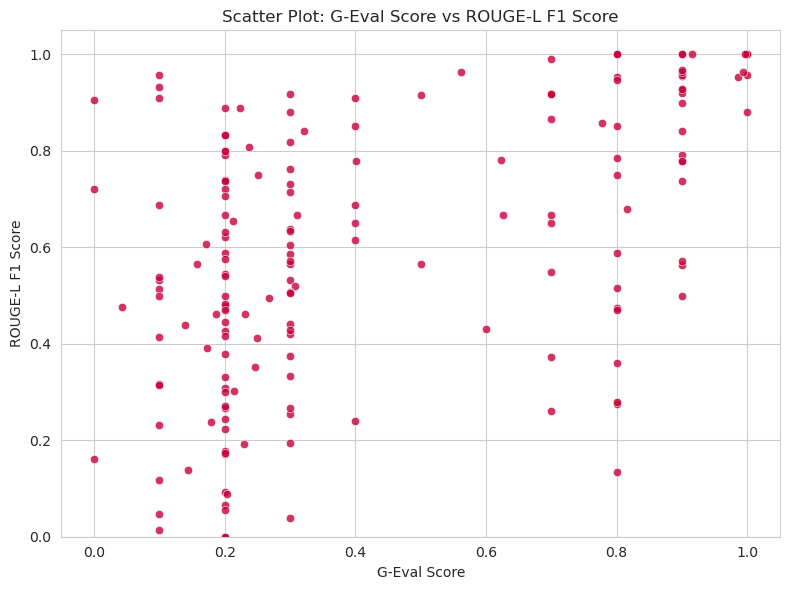

In [15]:
x = "G-Eval Score"
y = "ROUGE-L F1 Score"

plt.figure(figsize=(8, 6))
sns.scatterplot(data=metrics_df , x=x, y=y, color=custom_palette[5], alpha=0.8)
plt.title("Scatter Plot: " + x + " vs " + y)
plt.xlabel(x)
plt.ylabel(y)
plt.ylim(0, )
plt.grid(True)
plt.tight_layout()
plt.show()

### Boxplot of Evaluation Metrics

The boxplot offers a concise visual comparison of the evaluation metrics, BLEU, ROUGE-1, ROUGE-L, BERTScore (raw and normalized), and G-Eval, highlighting their differing behaviors. BLEU is heavily skewed toward lower values, reflecting its strictness toward rephrased but semantically valid responses. ROUGE-1 and ROUGE-L show similar, moderately higher distributions, consistent with their shared reliance on sequence overlap. Raw BERTScore is clustered near the top of the scale due to embedding similarity, while normalization spreads the scores more evenly, though both tend to overestimate quality in a domain like IYP. In contrast, G-Eval displays a distinctive bimodal distribution, clearly separating high- and low-quality outputs. This suggests G-Eval makes sharper judgments based on factual and semantic correctness, offering a more nuanced evaluation than the other metrics.

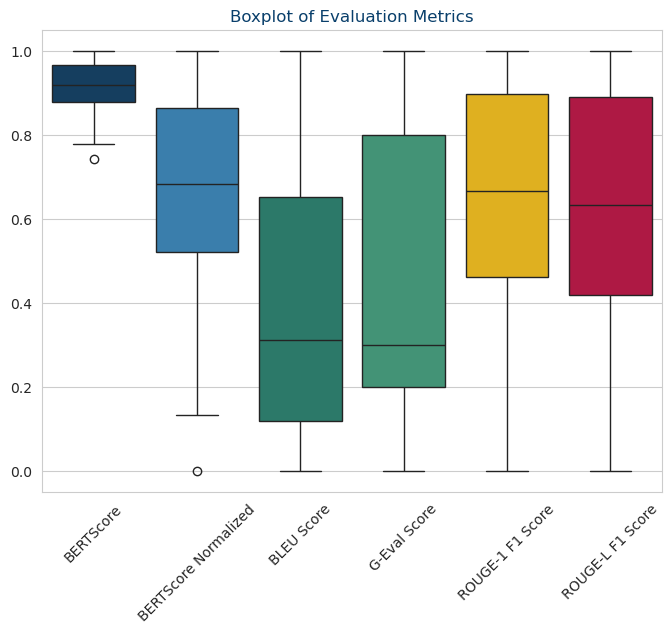

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=metrics_df[metric_columns], palette=custom_palette)
plt.title("Boxplot of Evaluation Metrics", color="#093F6B")
plt.xticks(rotation=45)
plt.show()

### Correlation heatmap for all metrics

The correlation matrix reveals how the evaluation metrics relate to one another. ROUGE-1 and ROUGE-L are nearly identical, with a correlation of 0.99, and both show strong alignment with normalized BERTScore (0.92). BLEU also correlates moderately with these metrics (around 0.84), despite its stricter scoring. In contrast, G-Eval shows weak correlation with all others (0.5–0.6), underscoring its focus on semantic and factual accuracy rather than lexical or embedding similarity. This independence highlights G-Eval’s role as a complementary metric, offering a distinct perspective in evaluating response quality.

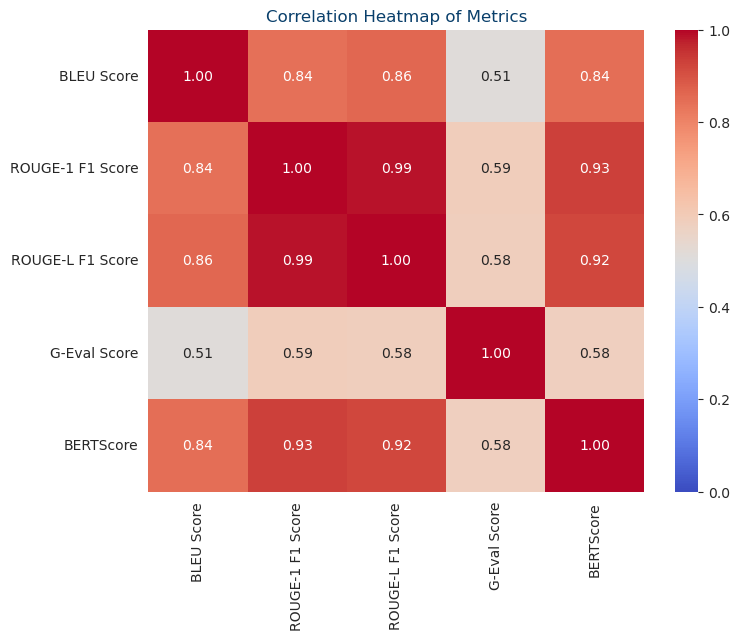

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df[metric_columns_no_norm].corr(), annot=True, cmap="coolwarm", fmt=".2f", vmin=0, vmax=1)
plt.title("Correlation Heatmap of Metrics", color="#093F6B")
plt.show()

***
## Difficulty Evaluation Section

### G-Eval Analysis

Model performance declines notably as prompt difficulty increases. Easy prompts tend to yield higher and more consistent G-Eval scores, while medium and hard prompts show broader score dispersion and generally lower values. This indicates that prompt complexity, rather than domain type, is the primary factor influencing output quality. Within each difficulty level, technical and general prompts perform similarly, though technical prompts slightly outperform general ones at easier levels. However, this trend reverses at the hardest level, where general prompts achieve better scores, likely due to the greater factual precision required in technical queries.

Across difficulty levels, there is a clear stepwise degradation in average scores: approximately a 30% drop from easy to medium prompts, followed by an additional 18% decline from medium to hard. The distribution of scores reflects a bimodal pattern, with responses tending to be rated either very high or very low, and few falling in between. Easier prompts dominate the high score range, while harder ones are more frequently rated lower. These results underscore the model’s current limitations in handling complex, nuanced queries and highlight the need for focused improvement on more challenging tasks.

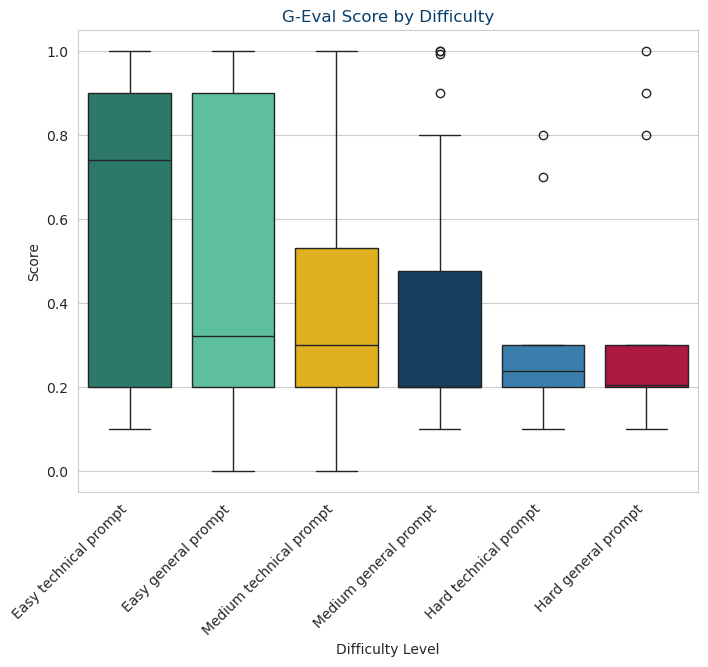

In [18]:
metric = 'G-Eval Score'

plt.figure(figsize=(8, 6))
sns.boxplot(x=difficulty_column, y=metric, data=metrics_df, palette=difficulty_palette)
plt.title(f'{metric} by Difficulty', color="#093F6B")
plt.xlabel("Difficulty Level")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.show()

#### Difficulty mean comparison table for G-Eval scores

The scores table summarizes the average performance of the RAG model across different prompt categories using G-Eval. It reveals a clear downward trend in mean scores as prompt difficulty increases, with easy prompts achieving the highest averages and hard prompts the lowest. While technical prompts slightly outperform general ones at the easy and medium levels, by approximately 8%, this advantage disappears at the hard level, where general prompts achieve higher average scores by about 12%. These shifts highlight how increased factual and structural complexity, particularly in technical queries, places greater strain on the model’s reasoning and grounding capabilities.

In [19]:
# Extract 'Level' and 'Type' from the 'Difficulty' column
df[['Level', 'Type']] = metrics_df['Difficulty'].str.extract(r'(\w+)\s+(\w+)\s+prompt')

# Create pivot table for mean G-Eval Score
pivot_table = df.pivot_table(
    values='G-Eval Score',
    index='Type',
    columns='Level',
    aggfunc='mean'
).reindex(index=['general', 'technical'], columns=['Easy', 'Medium', 'Hard'])

pivot_table

Level,Easy,Medium,Hard
Type,,,
general,0.523358,0.379017,0.341983
technical,0.576032,0.402405,0.301960


#### Stacked bar plot for different difficulties for G-Eval scores

The stacked bar plot of G-Eval scores across prompt difficulties reveals a distinct bimodal distribution, where most responses are concentrated at the lower (0.2–0.4) and upper (0.8–1.0) ends of the scale, with few in the midrange. This pattern reflects G-Eval’s tendency to deliver clear-cut assessments of response quality. Easier prompts are predominantly represented in the higher score bins, indicating more frequent generation of high-quality outputs. In contrast, medium and especially hard prompts are increasingly concentrated in the lower score ranges, underscoring the model’s declining performance as prompt complexity rises. This visual trend reinforces the conclusion that difficulty plays a central role in determining output quality.

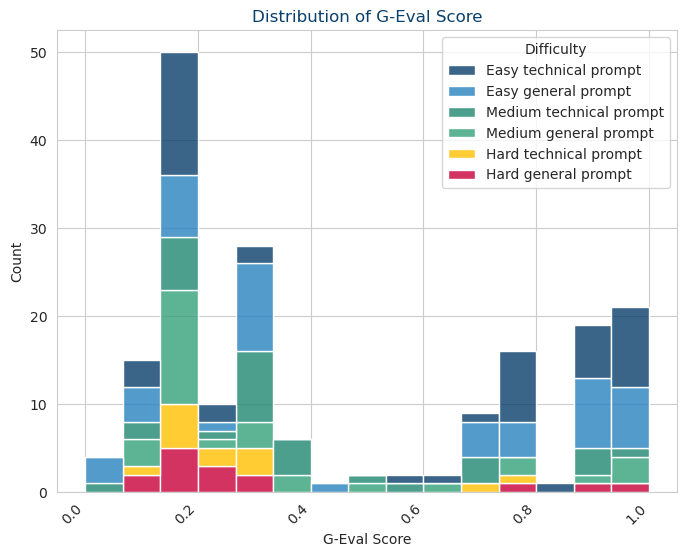

In [20]:
metric = 'G-Eval Score'

plt.figure(figsize=(8, 6))
sns.histplot(data=metrics_df, x=metric, hue='Difficulty', multiple='stack', kde=False, bins=bin_edges, palette=custom_palette, alpha=0.8)
plt.title(f'Distribution of {metric}', color="#093F6B")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.show()

### ROUGE-L Analysis

ROUGE-L scores were analyzed across prompt difficulty levels to complement the G-Eval findings. While the scores generally decrease as prompts become harder, the decline is more gradual and less distinct. The score distributions for easy, medium, and hard prompts overlap substantially, and differences between technical and general prompts are minimal, except at the medium level where technical prompts show a modest advantage. On average, the drop in ROUGE-L scores from easy to medium is slight, with a more noticeable decline from medium to hard. Score distribution patterns show that easy prompts tend to achieve high overlap, while hard prompts exhibit greater variability, often clustering around mid-range scores. Overall, ROUGE-L reflects the growing challenge of harder prompts but with less clarity than G-Eval, making it a less sensitive measure for semantic and factual evaluation.

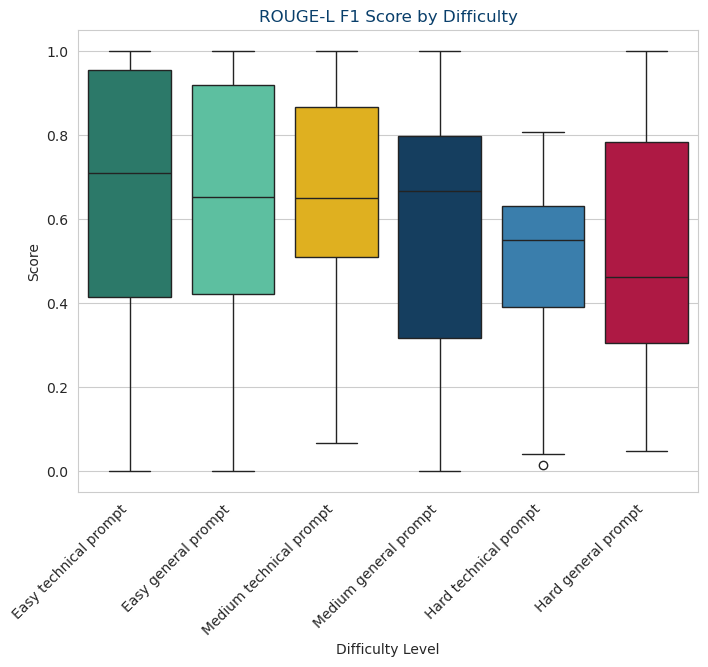

In [21]:
metric = 'ROUGE-L F1 Score'

plt.figure(figsize=(8, 6))
sns.boxplot(x=difficulty_column, y=metric, data=metrics_df, palette=difficulty_palette)
plt.title(f'{metric} by Difficulty', color="#093F6B")
plt.xlabel("Difficulty Level")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.show()

#### Difficulty mean comparison table for ROUGE-L scores

The mean ROUGE-L scores reveal a subtle pattern: performance is nearly the same for general and technical prompts at easy and hard difficulty levels, but at the medium level, technical prompts outperform general ones by about 10%, indicating a domain-specific advantage. The average score decreases slightly, around 5%, from easy to medium difficulty, then drops more noticeably by about 18% from medium to hard. This shows that ROUGE-L captures the increasing challenge of harder prompts, though less sharply than G-Eval.

In [22]:
# Extract 'Level' and 'Type' from the 'Difficulty' column
df[['Level', 'Type']] = metrics_df['Difficulty'].str.extract(r'(\w+)\s+(\w+)\s+prompt')

# Create pivot table for mean G-Eval Score
pivot_table = df.pivot_table(
    values='ROUGE-L F1 Score',
    index='Type',
    columns='Level',
    aggfunc='mean'
).reindex(index=['general', 'technical'], columns=['Easy', 'Medium', 'Hard'])

pivot_table

Level,Easy,Medium,Hard
Type,,,
general,0.636596,0.591328,0.508503
technical,0.658304,0.651569,0.495954


#### Stacked bar plot for different difficulties for ROUGE-L scores

The stacked bar plot shows the distribution of ROUGE-L scores across all prompt difficulties. Score bins are on the x-axis, and the number of responses per bin on the y-axis. Colors represent difficulty levels, revealing clear trends: easy prompts mostly score high (above 0.8), medium prompts have a wide spread across scores, and hard prompts display a bimodal pattern with peaks at low and mid scores. This indicates the model struggles more with harder prompts, resulting in less consistent output quality.

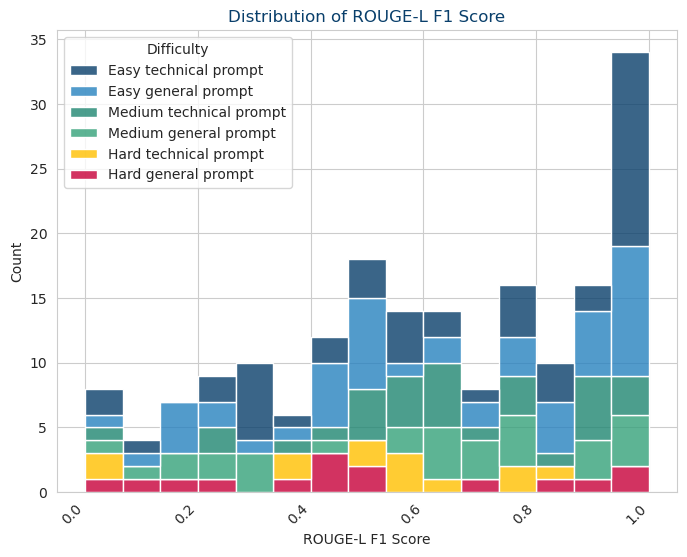

In [23]:
metric = 'ROUGE-L F1 Score'

plt.figure(figsize=(8, 6))
sns.histplot(data=metrics_df, x=metric, hue='Difficulty', multiple='stack', kde=False, bins=bin_edges, palette=custom_palette, alpha=0.8)
plt.title(f'Distribution of {metric}', color="#093F6B")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.show()

#### Difficulty correlation matrix

The difficulty correlation matrix shows how evaluation metrics relate across prompt difficulties and types. For easy and medium prompts, G-Eval has moderate correlation (~0.4–0.6) with others. In hard general prompts, G-Eval aligns strongly (~0.8) with other metrics, reflecting consistent poor performance. However, for hard technical prompts, correlation is weak or negative (~0.15), suggesting lexical metrics may overestimate quality while G-Eval detects deeper semantic or factual errors. This highlights G-Eval’s unique role in identifying critical issues in difficult technical cases.

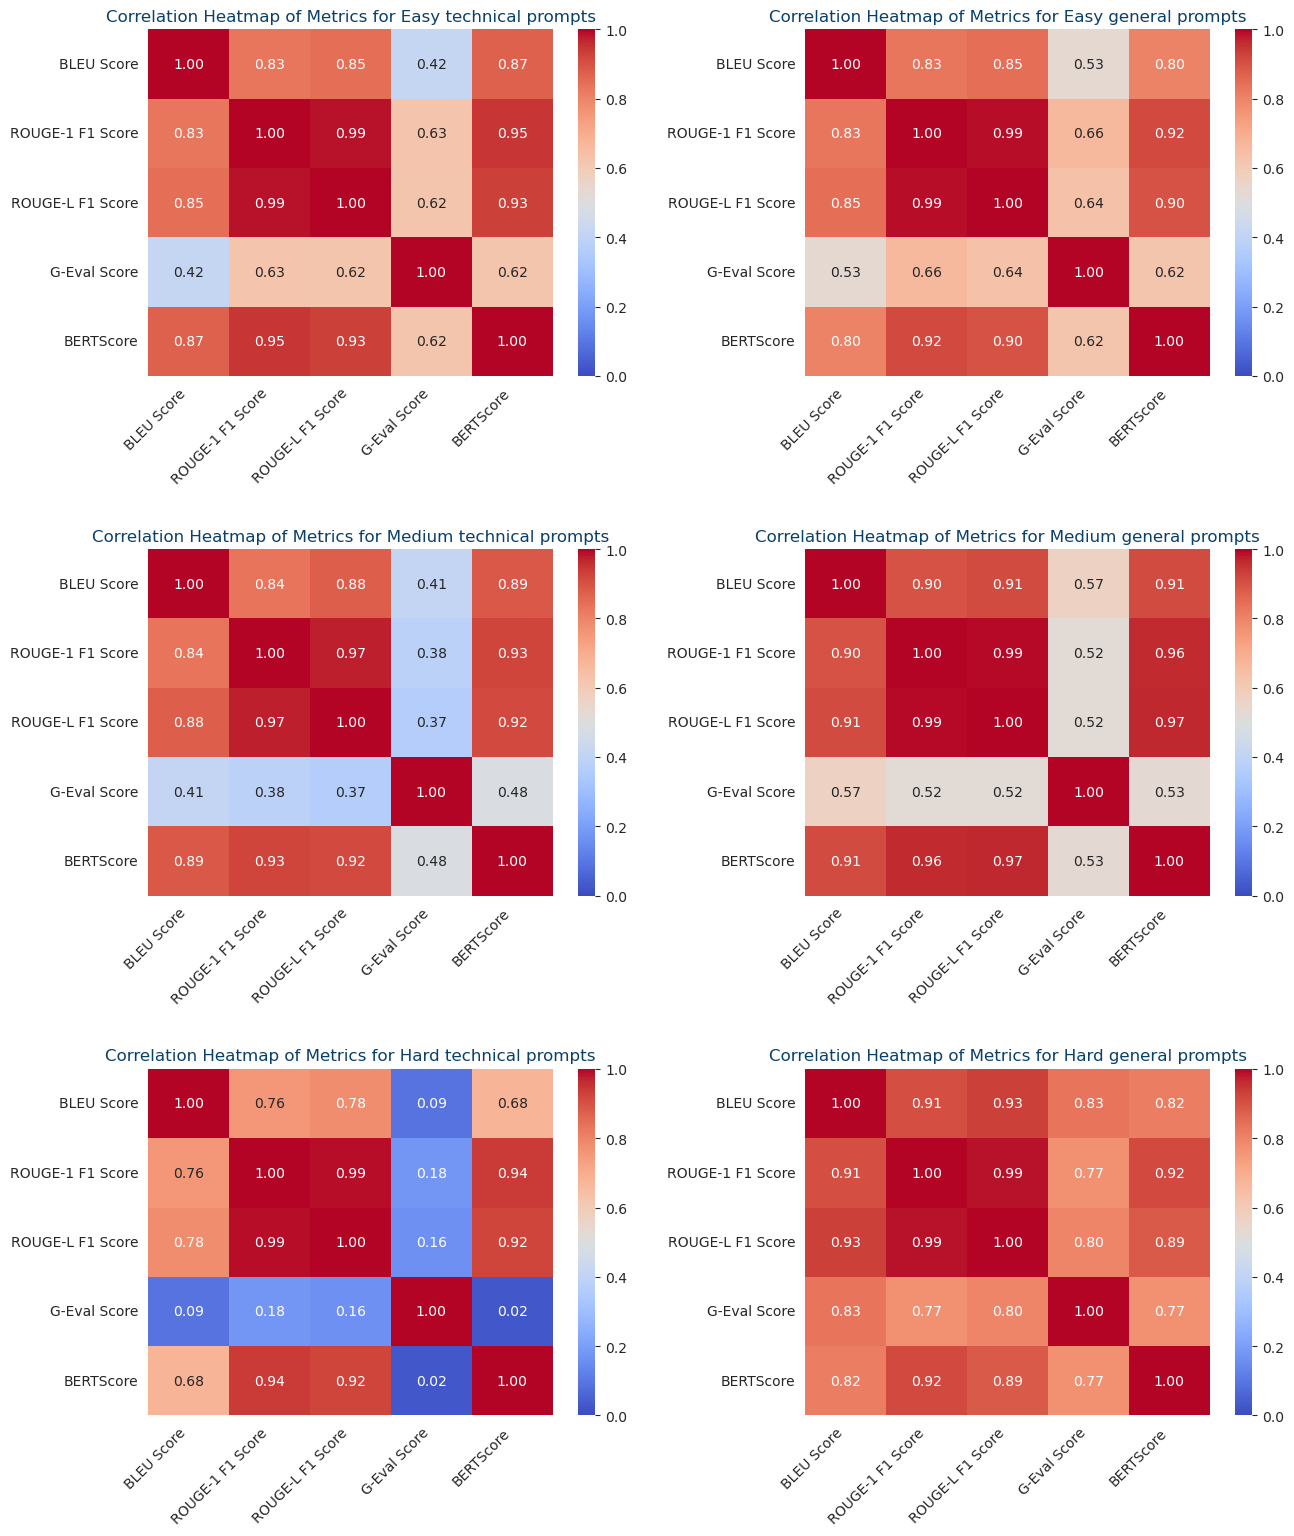

In [26]:
difficulties = metrics_df['Difficulty'].unique()

plt.figure(figsize=(15, 18))
for i, difficulty in enumerate(difficulties):
    df = metrics_df.loc[metrics_df['Difficulty'] == difficulty]
    plt.subplot(3, 2, i+1)
    sns.heatmap(df[metric_columns_no_norm].corr(), annot=True, cmap="coolwarm", fmt=".2f", vmin=0, vmax=1)
    plt.title("Correlation Heatmap of Metrics for " + difficulty + "s", color="#093F6B")
    plt.xticks(rotation=45, ha='right')  # Rotate x labels

plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase these values as needed
plt.show()